In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import pandas as pd
import numpy as np
import requests
from PIL import Image
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from marketplace_assistant.config import RAW_IMAGE_FILE_DIR, PROCESSED_DATA_DIR

# Using Image-to-Text Model to Caption Images

https://github.com/vikhyat/moondream

In [3]:
model_id = "vikhyatk/moondream2"
model = AutoModelForCausalLM.from_pretrained(
    model_id, trust_remote_code=True
).to("mps")
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [4]:
marketplace_data_path = PROCESSED_DATA_DIR / "marketplace_data.csv"
marketplace_data = pd.read_csv(marketplace_data_path, )

marketplace_data.sample(5)

,brand,bullet_point,item_id,item_name,product_type,main_image_id,other_image_id,path
56084,Stone & Beam,NaN,B075JQYVPX,Stone & Beam Medaillonteppich Mid-Century Mode...,HOME_FURNITURE_AND_DECOR,A194kPVvFmL,"['91BSu0qrBxL', 'A10sbjnmCZL', 'B1QJINggHqS', ...",f5/f54cda07.jpg
22347,AmazonBasics,NaN,B07PYL8KFT,AmazonBasics Poly Linear-Rib Commercial Carpet...,JANITORIAL_SUPPLY,91AX6REm4DL,NaN,bc/bcc50c4c.jpg
67527,Wickedly Prime (ウィキッドリープライム),原材料:かき(広島県)、大豆油、食塩; 商品サイズ(高さx奥行x幅):8cm×3.5cm×8cm,B07C9P2GGN,[Amazonブランド]Wickedly Prime Premiumおつまみ 広島県産 かき...,GROCERY,51z2bchLhuL,NaN,ba/ba0a7160.jpg
91705,Amazon Brand - Solimo,3D Printed Hard Back Case Mobile Cover for Sam...,B07TH33DXS,Amazon Brand - Solimo Designer Brush Art 3D Pr...,CELLULAR_PHONE_CASE,71fYdXMJp+L,"['61oI69Yt4GL', '61Xce1Hq7DL', '61ATVyzpLKL', ...",20/202bef71.jpg
65942,AmazonBasics,NaN,B079VPHBHH,AmazonBasics – Bombilla LED A19,LIGHT_BULB,71t13gdNCwL,"['51PFODvS-iL', '81okaYx67vL', '41bzKhec-0L']",8e/8e12dc81.jpg


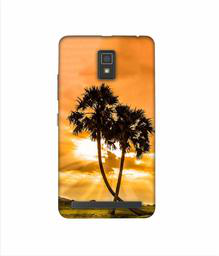

Amazon Brand - Solimo Designer SunSide View 3D Printed Hard Back Case Mobile Cover for Lenovo A6600


In [5]:
img_sample = marketplace_data.sample(1)
img_file = img_sample["path"].item()
img_desc = img_sample["item_name"].item()
img = Image.open(RAW_IMAGE_FILE_DIR / img_file)

display(img)
print(img_desc)


In [6]:
enc_image = model.encode_image(img)
print(model.answer_question(enc_image, "Describe this image.", tokenizer))

The image features a phone case with a palm tree silhouette against a sunset sky, with the palm tree's trunk and leaves in the foreground and the sun's rays peeking through the clouds in the background.


# Batched inference
Pass a list of image paths for batched inference

In [43]:
batch_size = 2
batch_sample = marketplace_data.sample(4)
data_len = len(batch_sample)

ans = []

for chunk in np.array_split(batch_sample, data_len / batch_size):
  chunk['full_path'] = str(RAW_IMAGE_FILE_DIR) + '/' + chunk['path'].astype(str)
  chunk_imgs = chunk['full_path'].tolist()
  chunk_imgs = [Image.open(name) for name in chunk_imgs]
  prompt = ["Write a caption that describes the object in the image in a concise manner."] * len(chunk)
  ans = ans + model.batch_answer(images=chunk_imgs, prompts = prompt, tokenizer = tokenizer)

batch_sample['ai_desc'] = ans

batch_sample

/Users/ashvath/anaconda3/envs/marketplace_assistant_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,brand,bullet_point,item_id,item_name,product_type,main_image_id,other_image_id,path,ai_desc
50172,Stone & Beam,Add the perfect accent to your transitional ho...,B0825F4JSR,Amazon Brand – Stone & Beam Contemporary Singl...,LIGHT_FIXTURE,41qY2ycBIlL,"['41f1-lownkL', '41dF6eD0qDL', '41tYRpJc9ZL', ...",e4/e429f3ae.jpg,A black wall sconce with a clear glass shade a...
131034,Teen Mix By Catwalk,आउटर मटीरियल: PU; क्लोज़र टाइप: स्लिप ऑन; हील ...,B07ZFQ3Z5K,Teen Mix By Catwalk Women's Black Fashion Slip...,SHOES,81BYawqCRaL,"['81fc+-FXjhL', '81fPhi2ubnL', '81a8ZWCePAL', ...",49/49f11f90.jpg,A black and white sandal with a black strap an...
71155,Strathwood by Amazon.com,直径为8.5英寸的分格四角椅子室外使用全天候坐垫面料束带固定边框; 耐磨 extruded-...,B008U4QR64,strathwood rhodes sectional 边角电脑椅; Strathwood ...,OUTDOOR_LIVING,71OQeuqgv4L,"['71yS3uO7-HL', '81ohUXT6RzL', '71xcU0aznXL', ...",ba/baad7129.jpg,A beige armchair with a black metal frame and ...
131347,Whole Foods Market,Brought to you by Whole Foods Market. When it...,B07KFZPDHQ,"Whole Foods Market, Triple Milled Soap, Coconu...",SKIN_CLEANING_AGENT,71lf7cDfoNL,"['71VGowiL6LL', '61X3oCd4ryL', '71iO0pl7oGL', ...",fc/fc620288.jpg,A white rectangular bar of coconut vanilla-fla...


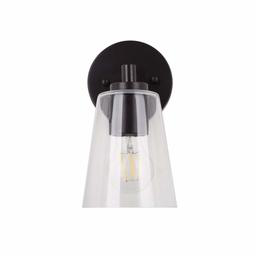

A black wall sconce with a clear glass shade and a single light bulb is mounted on a white wall.


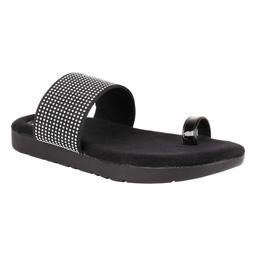

A black and white sandal with a black strap and a black ring on the toe is shown against a white background.


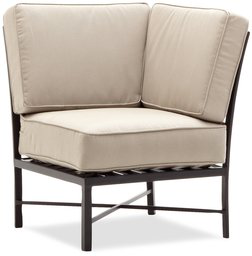

A beige armchair with a black metal frame and a black metal base is positioned against a white background.


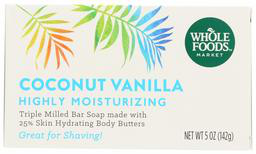

A white rectangular bar of coconut vanilla-flavored body soap from Whole Foods Market features a vibrant leaf design and a green "Great for Shaving!" label.


In [44]:
for index, row in batch_sample.iterrows():
    image = Image.open(RAW_IMAGE_FILE_DIR / row["path"])
    display(image)
    print(row["ai_desc"])
    